기한: 3월 8일 (금) 18:30

과제: 핸즈온 3장 분류 p.127-154 필사하여 깃허브에 업로드한 뒤, 깃허브 링크를 댓글로 달아주세요.

# CHAPTER 3. 분류
## 3.1 MNIST
MNIST 데이터셋: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 것

In [ ]:
#MNIST 데이터셋 다운로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #as_frame=False 추가함.
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런 데이터셋 특징

* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape
#이미지가 70,000개, 각 이미지에 784개의 특성 존재. 이미지가 28 x 28 픽셀이기 때문.
#특성: 픽셀 강도. 0(흰색)~255(검은색)

(70000, 784)

In [ ]:
y.shape

(70000,)

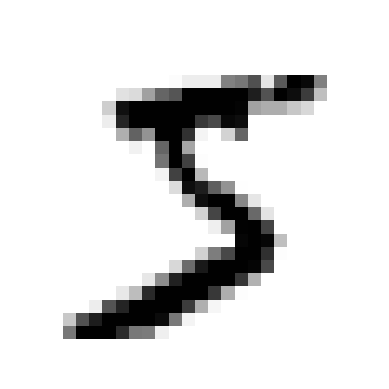

In [ ]:
#데이터셋에서 이미지 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
import numpy as np
y = y.astype(np.uint8)

데이터 조사 전 항상 테스트 세트를 따로 떼어놓아야 함!

MNIST 데이터셋은 훈련 세트(앞 60,000개)와 테스트 세트(뒤 10,000개)로 나누어놓음.

훈련 세트는 이미 섞여 있어 모든 교차 검증 폴드가 비슷함.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
이진 분류기(binary classifier): 두 개의 클래스를 구분



In [ ]:
#숫자 5만 식별해보자.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

분류 모델을 하나 선택해 훈련시켜보자.

사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD;Stochastic Gradient Descent) 분류기로 시작해 보자.

SGD: 한 번에 하나씩 훈련 샘플을 독립적으로 처리하므로 매우 큰 데이터셋을 효율적으로 처리함.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier는 훈련하는 데 무작위성을 사용함(그래서 '확률적'이라는 이름이 붙음)
결과를 재현하려면 random_state 매개변수를 지정해야 함.

In [ ]:
sgd_clf.predict([some_digit]) #숫자 5의 이미지 감지

array([ True])

##3.3 성능 측정
###3.3.1 교차 검증을 사용한 정확도 측정

교차 검증은 모델을 평가하는 좋은 방법임.
사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 때는 교차 검증 기능을 직접 구현하면 됨.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) #shuffle=True 추가함.

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함.

매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦.

그런 다음 올바른 예측의 수를 세어 정확한 예측비율을 출력함.

In [ ]:
#cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가
#k-겹 교차 검증: 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용하는 것
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3 , scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상.

In [ ]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 보자.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
#모델 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도 90% 이상.

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌.

특히 불균형한 데이터셋을 다룰 때(즉 어떤 클래스가 월등히 많을 경우).

###3.3.2 오차 행렬
오차 행렬(confusion matrix)

기본적인 아이디어: 클래스 A의 샘플이 클래스 B로 잘못 분류된 횟수를 세는 것.

오차 행렬을 만들기 위해서는 먼저 예측값을 만들어야 함. (실제 타깃과 비교하기 위함)

테스트 세트는 프로젝트의 맨 마지막(=분류기의 출시 준비 완료 후)에 사용되므로 여기에서 사용하지 않음.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict(): k-겹 교차 검증 수행. but 평가 점수 반환 X, 각 테스트 폴드에서 얻은 예측 반환 O.

즉, 모델이 훈련하는 데 쓰지 않은 데이터에 대해 예측한 것.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #행: 실제 클래스, 열: 예측한 클래스

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
#완벽한 분류기라면 오차 행렬의 주대각선만 0이 아닌 값이 됨.
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

정밀도(precision): 양성 예측의 정확도. TP/(TP+FP)
재현율(recall): 분류기가 정확하게 감지한 양성 샘플의 비율. TP/(TP+FN)

= 민감도(sensitivity), 진짜 양성 비율(true positive rate(TPR)

###3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 score: 정밀도와 재현율의 조화 평균(harmonic mean)
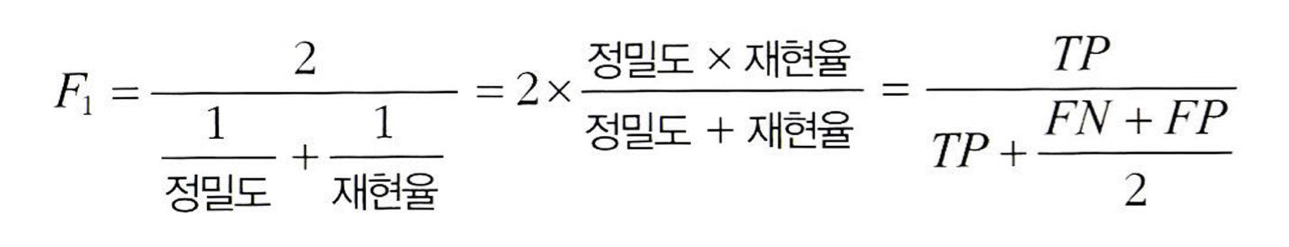

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음. -> 항상 바람직한 것은 아님. 상황에 따라 다름

###3.3.4 정밀도/재현율 트레이드오프

* 정밀도를 높이면 재현율이 낮아짐. 재현율을 높이면 정밀도가 낮아짐.

* SGDClassifier:

    결정 함수(decision function)로 각 샘플의 점수 계산.

    이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당 / 작으면 음성 클래스에 할당

* 결정 임곗값(decision threshold)




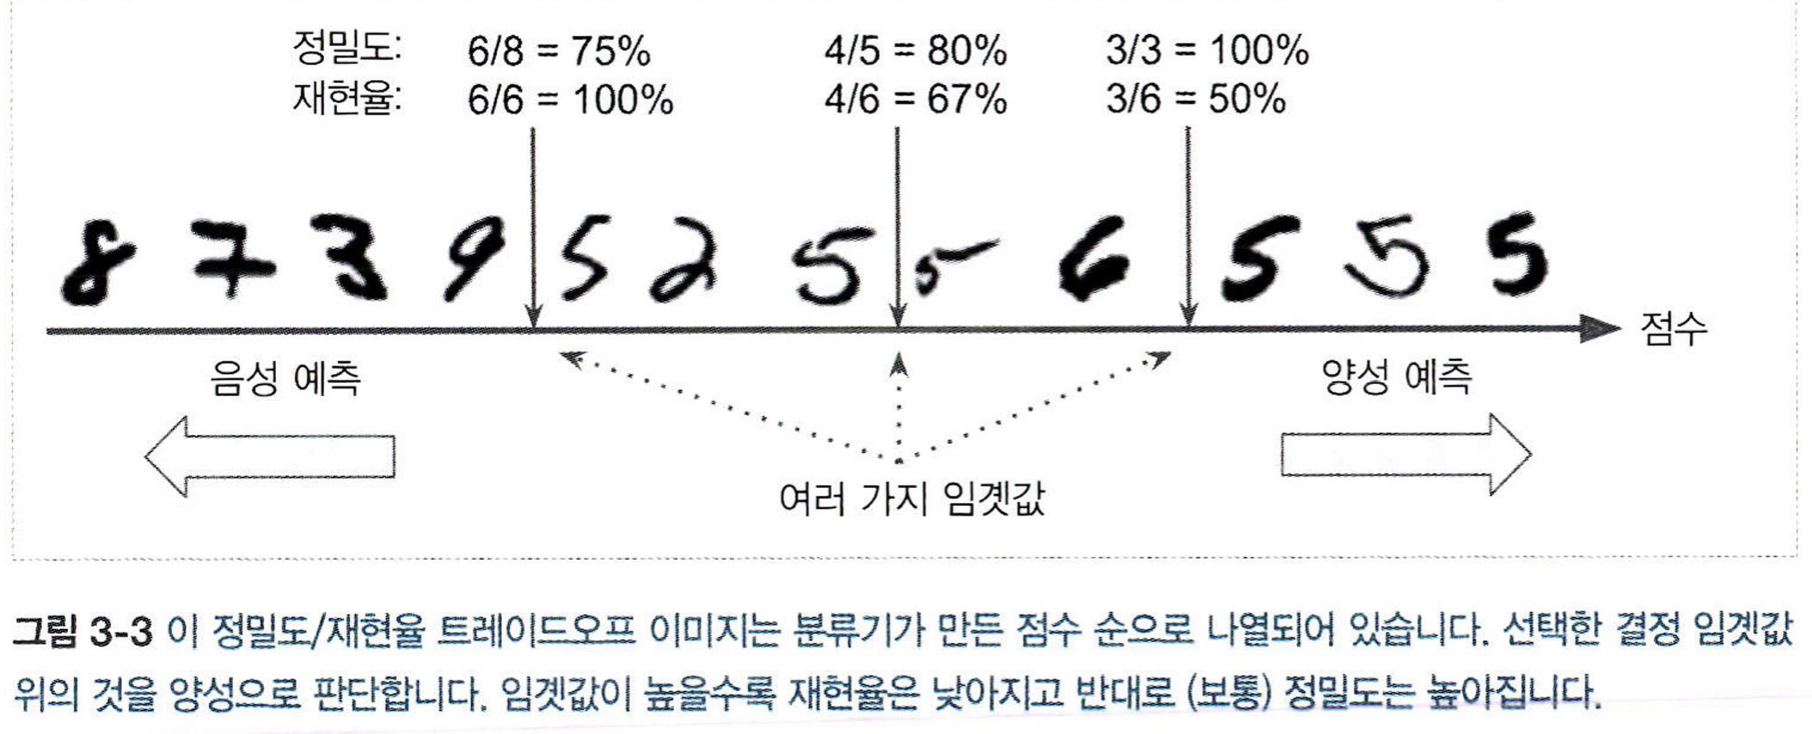

In [ ]:
#각 샘플의 점수 계산
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
#SGDClassifier의 임곗값이 0이므로 predict() 메서드와 같은 결과를 반환함

In [ ]:
threshold = 8000 #임곗값 높임
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#재현율이 줄어듦.

array([False])

적절한 임곗값 정하기: 모든 훈련 샘플의 점수 구하기 -> 결정 점수를 반환받도록 지정하기

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = "decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve
#가능한 모든 임곗값에 대해 정밀도와 재현율 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

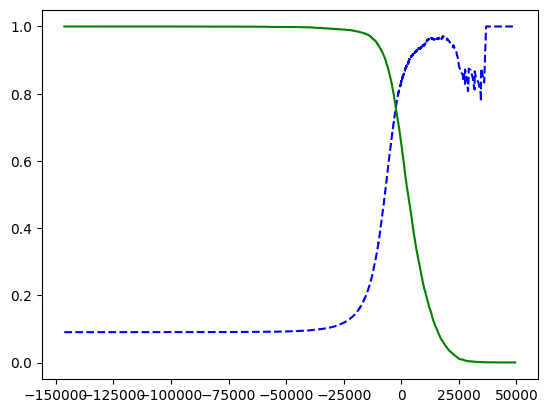

In [ ]:
#이제 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있음
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

* 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있음.
* 재현율은 임곗값이 올라감에 따라 줄어들 수밖에 없음.

다른 방법: 재현율에 대한 정밀도 곡선 그리기

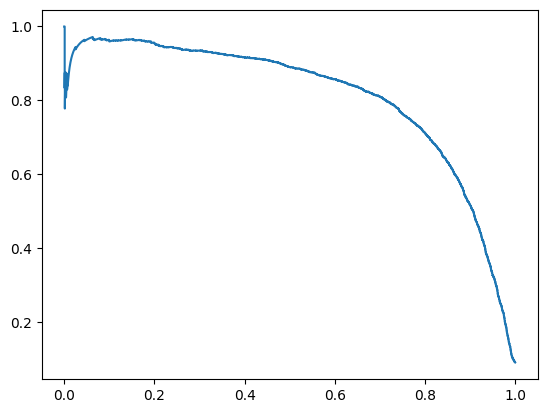

In [ ]:
plt.plot(recalls, precisions) #전체 범위
plt.show()

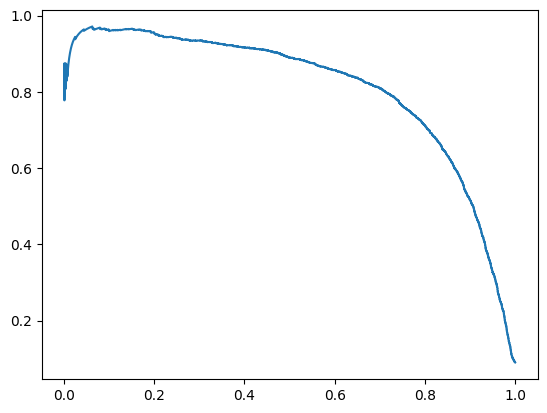

In [ ]:
plt.plot(recalls[precisions<1], precisions[precisions<1]) #1 미만
plt.show()

재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함.

이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음. e.g.재현율이 60% 정도인 지점.

가상의 정밀도에 대해서 분류기를 만들어 보자.

In [ ]:
#목표가 정밀도 90% 달성이라면
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
#이 예측에 대한 정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않음.

###3.3.5 ROC 곡선
수신기 조작 특성(Receiver operating characteristic; ROC): 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선.

거짓 양성 비율: 양성으로 잘못 분류된 음성 샘플의 비율. 1-TNR(True Negative Rate)

TNR = 특이도(specificity)

-> ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

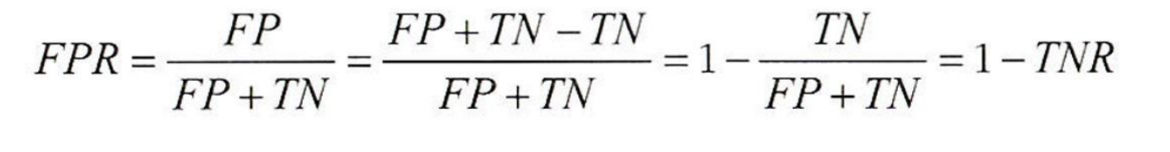

In [ ]:
#ROC 곡선을 그리려면 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 함
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

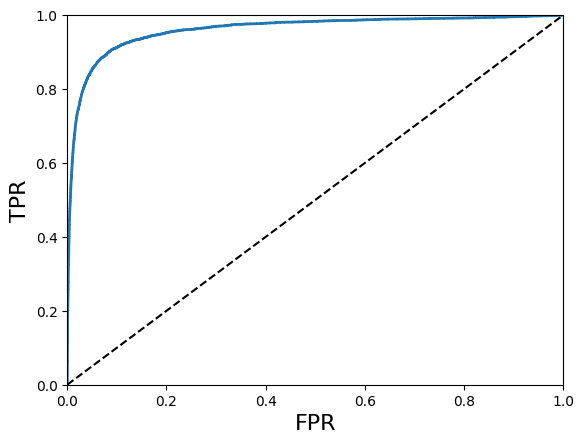

In [ ]:
#맷플롯립 사용해 TPR에 대한 FPR 곡선 나타낼 수 있음
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

여기에도 트레이드오프 있음.

재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남.

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함.

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함. (왼쪽 위 모서리)

곡선 아래의 면적(Area Under the Curve; AUC)을 측정하면 분류기들을 비교할 수 있음.

완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* PR 곡선 vs ROC 곡선

일반적으로,

양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요 -> PR 곡선 사용

그렇지 않으면 -> ROC 곡선 사용

In [ ]:
#ROC 곡선과 ROC AUC 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
#양성 클래스 확률을 점수로 사용
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

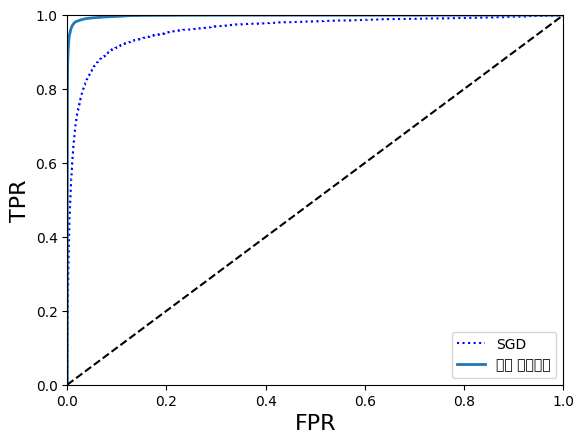

In [ ]:
#두가지 ROC 곡선 함께 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

ROC 곡선 비교: LF분류기가 SGD분류기보다 훨씬 좋음. AUC 값이 크기 때문(왼쪽 위 모서리에 더 가까움)

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##3.4 다중 분류
다중 분류기(Multiclass classifier) 또는 다항 분류기(Multinomial classifier): 둘 이상의 클래스를 구별할 수 있음.

OvR(one-versus-the-rest) 또는 OvA(one-versus-all) 전략: 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

OvO(one-versus-one) 전략: 각 숫자의 조합마다 이진 분류기를 훈련

OvO 전략의 장점: 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것

In [ ]:
#서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함.

In [ ]:
#decision_function() 메서드를 호출하면 샘플당 10개의 점수를 반환함. 이 점수는 클래스마다 한 개씩 있음.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores #가장 높은 점수가 클래스 5에 해당하는 값임.

array([2164.22030239])

In [ ]:
np.argmax(some_digit_scores)

0

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

주의) 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함.

위 예제에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같음.

즉, 인덱스 5에 해당하는 클래스의 값은 5임. 하지만 일반적으로 이런 경우는 드묾.

사이킷런에서 OvO나 OvR을 사용하도록 강제하는 방법: OneVsOneClassifier나 OneVsRestClassifier 사용

In [ ]:
#SVC 기반으로 OvR 전략 사용하는 다중 분류기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

45

In [ ]:
#SGDClassifier(또는 RandomForestClassifier) 훈련
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
#SGD분류기는 직접 샘플로 다중 클래스로 분류할 수 있으므로 별도로 OvR이나 OvO를 적용할 필요 없음.
#decision_function(): 클래스마다 하나의 값 반환
#SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
#정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
#입력 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

##3.5 에러 분석

In [ ]:
#오차 행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#오차 행렬 matshow()함수로 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

주대각선: 대부분의 이미지가 올바르게 분류되었음을 나타냄

In [ ]:
#에러 비율 비교하기
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
#주대각선을 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

클래스 8의 열이 밝음: 많은 이미지가 8로 잘못 분류됨

클래스 8의 행이 어두움: 실제 8이 적절히 8로 분류됨

-> 8로 잘못 분류되는 것을 줄일 필요가 있음.

* 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음!

In [ ]:
#맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

에러 원인: 선형 모델인 SGDClassifier 사용했기 때문.

에러 줄이는 방법: 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것.

##3.6 다중 레이블 분류
다중 레이블 분류(multilabel classification): 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
#다중 레이블 분류기 평가 - F1 점수의 평균 계산
#모든 레이블의 가중치가 같다고 가정한 것임.
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

레이블에 클래스의 지지도(support; 타깃 레이블에 속한 샘플 수)를 가중치로 두는 것.

average="weighted" 로 설정하면 됨

##3.7 다중 출력 분류
다중 출력 다중 클래스 분류(Multioutput-multiclass classification) 또는 다중 출력 분류(multioutput classification):

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것.

즉, 값을 두 개 이상 가질 수 있음.

In [ ]:
#픽셀 강도에 잡음 추가. 타깃 이미지는 원본 이미지가 될 것임
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
#테스트 세트에서 이미지 선택
some_index = 1
plt.subplot(121); plot_digits(X_test_mod[some_index])
plt.subplot(122); plot_digits(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)